## sigMF STFT on GPU and CPU respectively

In [7]:
import os
import itertools
from sklearn.utils import shuffle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as d
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.modules as mod
import torch.utils.data
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.autograd import Variable
import numpy as np
import sys
import importlib
import time
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import librosa
from scipy import signal
from scipy import stats
from scipy.special import comb
import matplotlib.pyplot as plt
import glob
import json
import pickle
from random import randint, choice
import random
from timeit import default_timer as timer
import psutil
from torch import istft
global GPU, n_fft
GPU = 1
Fs = 125000000
n_fft = 1024
plt.style.use('default')
device = torch.device('cuda:1')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:1
Is cuda available? = True


#### Old Torch 1.0.0 Cuda 9.0.176 running faster on GPU

In [3]:
# %matplotlib notebook
# %matplotlib inline

#### Machine paths

In [2]:
path = "/home/david/sigMF_ML/SVD/data/" 
path_save = "/home/david/sigMF_ML/SVD/" 
path3 = "/home/david/sigMF_ML/class2/data3/"
print(path3)

/home/david/sigMF_ML/class2/data3/


In [3]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

In [4]:
print(path3)
os.chdir(path3)
data_files = sorted(glob.glob('*'))
# meta_files = sorted(glob.glob('*.sigmf-meta'))

/home/david/sigMF_ML/class2/data3/


In [5]:
for i in data_files:
    print("file name = ", i)

file name =  DJI_LB2_0001
file name =  DSM2_0001
file name =  DragonLink_0001
file name =  EzUHFJR_0001
file name =  FASSTest_14SG_0001
file name =  FrSkyT_QX7_0001
file name =  FrSkyT_R9M_0001
file name =  FrSkyT_X9D_0001
file name =  FrSky_DJT_0001
file name =  Lumenier_TX5G6R_0001
file name =  Mavic_Pro_0001
file name =  P3A_0001
file name =  P3S_0001
file name =  RFD900+_0001
file name =  TBSUnifyPro_0001
file name =  TBS_CRFS_0001


In [1]:
# for meta in meta_files:
#     all_meta_data = json.load(open(meta))
#     print("file name = ", meta)

### Pytorch GPU function : Concatenate on GPU

In [12]:
def gpu(db):
    I = db[0::2]
    Q = db[1::2]
    start = timer()
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=True)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
    X_stft = torch.cat((X_stft[n_fft//2:],X_stft[:n_fft//2]))
    end = timer()
    x = end - start
    torch.cuda.empty_cache()
    return X_stft, I_stft, Q_stft, x

### Scipy CPU function

In [15]:
def cpu(db):
    t = len(db)
    db2 = db[0::]
    start = timer()
    db = db.astype(np.float32).view(np.complex64)
    Fs = 1e6
    I_t, I_f, Z = signal.stft(db, fs=Fs, nperseg=n_fft, return_onesided=False)
    Z = np.vstack([Z[n_fft//2:], Z[:n_fft//2]])
    end = timer()
    x = end - start
#     print(x)
    return Z, x

### GPU Timing

In [18]:
gpu_time = np.zeros((2,len(data_files)))
for i, file in enumerate(data_files):
    db = np.fromfile(file, dtype="float32")
    stft_gpu, I_stft, Q_stft, x = gpu(db)
    gpu_time[0,i] = x
    gpu_time[1,i] = int(i+1)    

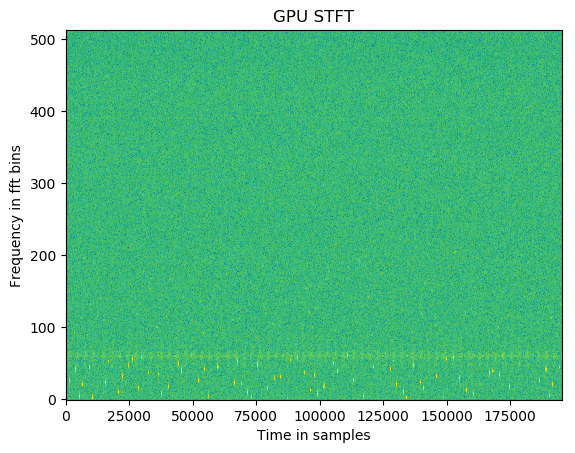

In [14]:
plt.figure(figsize=(12, 12))
fig = plt.figure()
plt.imshow(20*np.log10(np.abs(stft_gpu.cpu()+1e-8)), aspect='auto', origin='lower')
plt.title('GPU STFT')
plt.xlabel('Time in samples')
plt.ylabel('Frequency in fft bins')
fig.savefig('gpu_stft.png', format="png")
plt.show()

### CPU Timing

In [16]:
cpu_time = np.zeros((2,len(data_files)))
for i, file in enumerate(data_files):
    db = np.fromfile(file, dtype="float32")
    stft_cpu, x = cpu(db)
    cpu_time[0,i] = x
    cpu_time[1,i] = int(i+1)

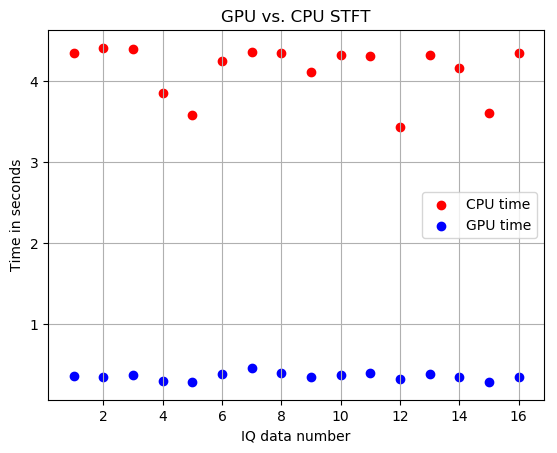

In [19]:
plt.figure(figsize=(12, 12))
fig = plt.figure()
plt.scatter(cpu_time[1,:],cpu_time[0,:], c='r', label='CPU time')
plt.scatter(gpu_time[1,:],gpu_time[0,:], c='b', label='GPU time')
plt.title('GPU vs. CPU STFT')
plt.xlabel('IQ data number')
plt.ylabel('Time in seconds')
plt.grid()
plt.legend()
fig.savefig('cpu_gpu_time_125MSPS.png', format="png")
plt.show()
# plt.savefig(fig, format="png")

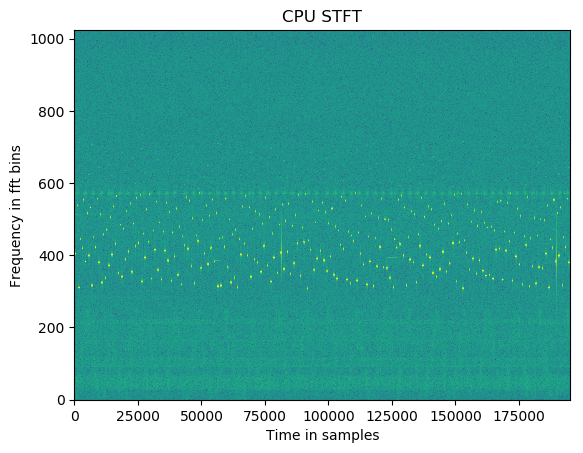

In [20]:
# plt.figure(figsize=(12, 12))
fig = plt.figure()
plt.imshow(20*np.log10(np.abs(stft_cpu+1e-8)), aspect='auto', origin='lower')
plt.title('CPU STFT')
plt.xlabel('Time in samples')
plt.ylabel('Frequency in fft bins')
fig.savefig('cpu_stft.png', format="png")
plt.show()

### GPU SVD

In [ ]:
def udv_stft(I_stft,Q_stft):
    start = timer()
    U_I0, D_I0, V_I0 = torch.svd(I_stft[...,0]) 
    U_I1, D_I1, V_I1 = torch.svd(I_stft[...,1]) 
    U_Q0, D_Q0, V_Q0 = torch.svd(Q_stft[...,0]) 
    U_Q1, D_Q1, V_Q1 = torch.svd(Q_stft[...,1]) 
    end = timer()
    print('SVD time: ',end - start)
    return U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1

### GPU ISTFT

In [ ]:
def ISTFT(db):
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    start = timer()
    Z = istft(db, n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    end = timer()
    print('ISTFT time = ',end - start)
    torch.cuda.empty_cache()
    return Z

#### Re-combine UDV to approximate original signal¶

In [ ]:
def udv(u, d, v, k):
    start = timer()
    UD = torch.mul(u[:, :k], d[:k])
    v = torch.transpose(v,1,0)
    UDV = torch.mm(UD, v[:k, :])
    end = timer()
    print('UDV time: ',end - start)
    return UDV

### GPU Main Routine

In [ ]:
def complete(I_stft,Q_stft, num):
    U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1 = udv_stft(I_stft,Q_stft)
    torch.cuda.empty_cache()
    print('UDV I0 shapes = ',U_I0.shape, D_I0.shape, V_I0.shape)
    print('UDV I1 shapes = ',U_I1.shape, D_I1.shape, V_I1.shape)
    print('UDV Q0 shapes = ', U_Q0.shape, D_Q0.shape, V_Q0.shape)
    print('UDV Q1 shapes = ', U_Q1.shape, D_Q1.shape, V_Q1.shape)
    # ------------ I0 ------------------------------------------------------
    np.save('U_I0', U_I0[:, :num].detach().cpu().numpy())
    np.save('D_I0', D_I0[:num].detach().cpu().numpy())
    np.save('V_I0', V_I0[:num, :].detach().cpu().numpy())
    # ------------ I1 ------------------------------------------------------
    np.save('U_I1', U_I1[:, :num].detach().cpu().numpy())
    np.save('D_I1', D_I1[:num].detach().cpu().numpy())
    np.save('V_I1', V_I1[:num, :].detach().cpu().numpy())
    # ------------ Q0 ------------------------------------------------------
    np.save('U_Q0', U_Q0[:, :num].detach().cpu().numpy())
    np.save('D_Q0', D_Q0[:num].detach().cpu().numpy())
    np.save('V_Q0', V_Q0[:num, :].detach().cpu().numpy()) 
    # ------------ Q1 ------------------------------------------------------
    np.save('U_Q1', U_Q1[:, :num].detach().cpu().numpy())
    np.save('D_Q1', D_Q1[:num].detach().cpu().numpy())
    np.save('V_Q1', V_Q1[:num, :].detach().cpu().numpy())    
    # -----------------------------------------------------------------------
    udv_I0 = udv(U_I0, D_I0, V_I0,num)
    udv_I1 = udv(U_I1, D_I1, V_I1,num)
    udv_Q0 = udv(U_Q0, D_Q0, V_Q0,num)
    udv_Q1 = udv(U_Q1, D_Q1, V_Q1,num)
    torch.cuda.empty_cache()
    print('udv I shapes = ',udv_I0.shape,udv_I1.shape)
    print('udv Q shapes = ',udv_Q0.shape,udv_Q1.shape)
    # -------------stack and transpose----------------------------------------
    UDV_I = torch.stack([udv_I0,udv_I1])
    UDV_I = torch.transpose(UDV_I,2,0)
    UDV_I = torch.transpose(UDV_I,1,0)
    UDV_Q = torch.stack([udv_Q0,udv_Q1])
    UDV_Q = torch.transpose(UDV_Q,2,0)
    UDV_Q = torch.transpose(UDV_Q,1,0)
    torch.cuda.empty_cache()
    #--------------------------------------------------------------------------
    I = ISTFT(UDV_I)
    Q = ISTFT(UDV_Q)
    torch.cuda.empty_cache()
    I = I.detach().cpu().numpy()
    Q = Q.detach().cpu().numpy()
    end = len(I)*2
    IQ_SVD = np.zeros(len(I)*2)
    IQ_SVD[0:end:2] = I
    IQ_SVD[1:end:2] = Q 
    IQ_SVD = IQ_SVD.astype(np.float32).view(np.complex64)
    return IQ_SVD

#### GPU Re-construction

In [ ]:
num = 2 # number to reconstruct SVD matrix from
IQ_SVD = complete(I_stft,Q_stft, num)

In [23]:
calc_time = np.zeros((1,len(data_files)))
calc_time = cpu_time[0,:]/gpu_time[0,:]

### GPU Vs. CPU speed up: value means GPU is x times faster than CPU

In [24]:
for i, value in enumerate(calc_time):
    print ('i = %d, value = %.10f'%(i,value))

i = 0, value = 12.0782548758
i = 1, value = 12.5996310373
i = 2, value = 11.7972872108
i = 3, value = 12.7145230737
i = 4, value = 12.5167254210
i = 5, value = 11.1080523454
i = 6, value = 9.5153774536
i = 7, value = 10.9759963315
i = 8, value = 11.7377853810
i = 9, value = 11.6102973944
i = 10, value = 10.6629797114
i = 11, value = 10.5747192373
i = 12, value = 11.1673838190
i = 13, value = 11.9454943369
i = 14, value = 12.5021276200
i = 15, value = 12.4252889554


### GPU raw STFT computation time in seconds

In [25]:
for i, value in enumerate(gpu_time[0,:]):
    print ('i = %d, value = %.10f'%(i,value)) 
    

i = 0, value = 0.3594645910
i = 1, value = 0.3503545280
i = 2, value = 0.3724112190
i = 3, value = 0.3028744710
i = 4, value = 0.2866390930
i = 5, value = 0.3822933500
i = 6, value = 0.4580646250
i = 7, value = 0.3958012450
i = 8, value = 0.3499928390
i = 9, value = 0.3725534600
i = 10, value = 0.4048030600
i = 11, value = 0.3248718050
i = 12, value = 0.3871992730
i = 13, value = 0.3480187550
i = 14, value = 0.2887771160
i = 15, value = 0.3494869810


### CPU raw STFT computation time in seconds

In [26]:
for i, value in enumerate(cpu_time[0,:]):
    print ('i = %d, value = %.10f'%(i,value)) 

i = 0, value = 4.3417049490
i = 1, value = 4.4143377850
i = 2, value = 4.3934421110
i = 3, value = 3.8509044500
i = 4, value = 3.5877828220
i = 5, value = 4.2465345430
i = 6, value = 4.3586578050
i = 7, value = 4.3443130130
i = 8, value = 4.1081408290
i = 9, value = 4.3254564660
i = 10, value = 4.3164068160
i = 11, value = 3.4354281260
i = 12, value = 4.3240028960
i = 13, value = 4.1572560670
i = 14, value = 3.6103283580
i = 15, value = 4.3424767250
